In [ ]:
!git add .

In [122]:
!git commit -m "Duplicado notebook para ter um de apresentação e outro para realizar a serialização com o pickle. Criado também os .py para a criação da API com flask"

[main 51deeaf] Duplicado notebook para ter um de apresentação e outro para realizar a serialização com o pickle. Criado também os .py para a criação da API com flask
 5 files changed, 4195 insertions(+), 373 deletions(-)
 create mode 100644  healthinsurance/HealthInsurance.py
 create mode 100644 2_0_health_insurance_cross_sell.ipynb
 create mode 100644 handler.py
 create mode 100644 model_linear_regression.pkl


In [123]:
!git push origin main

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 4 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (8/8), 258.60 KiB | 2.81 MiB/s, done.
Total 8 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), done.
To github.com:wilianuhlmann/health_insurance_cross_sell.git
   040ca93..51deeaf  main -> main


## The problem:

Uma empresa de seguros de saúde precisa detectar os clientes que são mais propensos a comprar um seguro de automóvel. 

O desafio é calcular a propensão de compra de cada cliente da base e retornar para o time de negócio, uma lista priorizada, começando pelo cliente mais propenso até o menor propenso.

# 0.0. Imports

## 0.1. lib imports

In [4]:
from acessos import database_name, host, port, user, password
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql

## 0.2 Helper Functions

In [5]:
def conn:
    pass

SyntaxError: invalid syntax (1559221371.py, line 1)

# 1.0. Schema Query

In [ ]:
conn = pg.connect(user = user, 
                  password = password,
                  host = host,
                  port = port,
                  database = database_name)

In [ ]:
cursor = conn.cursor()
query_schema = """
                    SELECT nspname
                    FROM pg_catalog.pg_namespace
"""

In [ ]:
cursor.execute(query_schema)
record = cursor.fetchall()
cursor.close()
conn.close()

In [ ]:
print(record)

# 2.0. Table Query

In [ ]:
cursor = conn.cursor()
query_schema = """
                    SELECT tablename
                    FROM pg_tables
                    WHERE schemaname='pa004'
"""

cursor.execute(query_schema)
record = cursor.fetchall()
cursor.close()
conn.close()

In [ ]:
print(record)

# 3.0. Collect Data using Psycopg2

In [ ]:
cursor = conn.cursor()
query_tables_users = """
                    SELECT *
                    FROM pa004.users u
                    WHERE u.age > 44
                    LIMIT 10
"""

cursor.execute(query_tables_users)
record = cursor.fetchall()
print(record)
cursor.close()
conn.close()

# 4.0. Collect Data using Pandas

In [ ]:
query_tables_users = """
                    SELECT *
                    FROM pa004.users u
                    INNER JOIN pa004.vehicle v ON (u.id = v.id)
                    INNER JOIN pa004.insurance i ON (u.id = i.id)
                    WHERE u.age > 44
                    LIMIT 10
"""
# AND date > '2019-01-01' AND date < '2020-03-01'


In [ ]:
# Forma antiga de usar
df = psql.read_sql(query_tables_users, conn)
df.head

In [ ]:
df1 = pd.read_sql(query_tables_users, conn)
df1 = df1.drop(df1.columns[[5, 9]], axis=1)
df1.head()

In [6]:
df1.columns

NameError: name 'df1' is not defined

# =================================================================================================

# 0.0. Imports

In [111]:
from acessos import database_name, host, port, user, password
import psycopg2 as pg
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas.io.sql as psql
import pickle

import scikitplot as skplt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model    as lm

## 0.1. Load dataset

In [45]:
df_raw = pd.read_csv('data/train.csv')

In [46]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [47]:
df1 = df_raw.copy()

In [48]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [49]:
columns_news = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

In [50]:
df1.columns = columns_news

In [51]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.1. Data Dimension

In [52]:
print('Columns: {}'.format(df1.shape[1]))
print('Row: {}'.format(df1.shape[0]))

Columns: 12
Row: 381109


## 1.2. Data Types

In [53]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NAs

In [54]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [55]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [56]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature engineering 

In [57]:
df2 = df1.copy()

In [58]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2' if x == '1-2 Year' else 'below_1_year')
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [59]:
df3 = df2.copy()

# 4.0 Explore Data Analyses 

In [60]:
df4 = df3.copy()

## 4.1. Univariate Analysis

<AxesSubplot:xlabel='response', ylabel='age'>

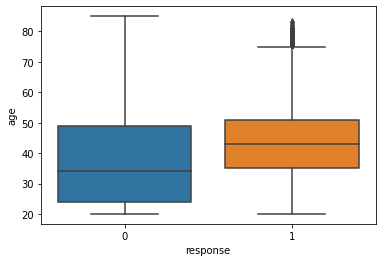

In [61]:
 #'age'
sns.boxplot( x='response', y='age', data=df4 )

<AxesSubplot:xlabel='age', ylabel='Count'>

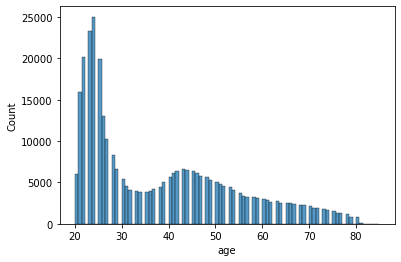

In [62]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

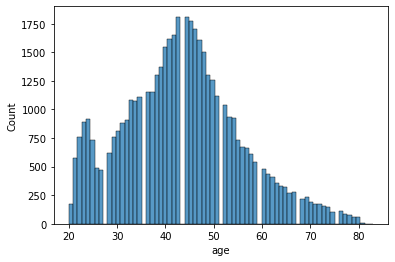

In [63]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

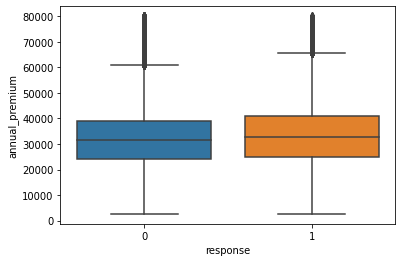

In [64]:
#'annual_premium'
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

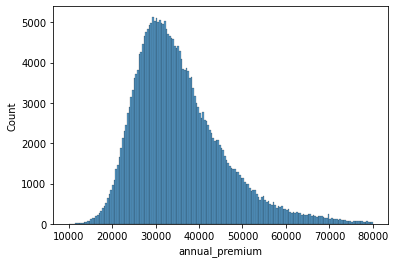

In [65]:
aux = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000 )]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

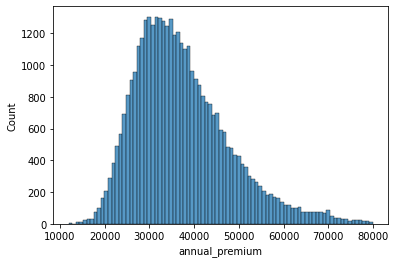

In [66]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 )

In [67]:
#'driving_license'
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux.head()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
#sns.barplot( x='response', y='driving_license', data=aux )

<AxesSubplot:xlabel='region_code', ylabel='id'>

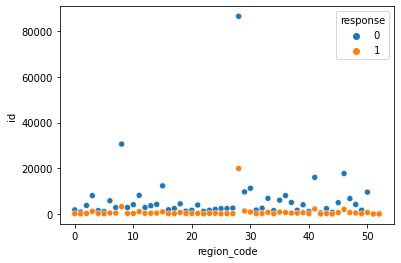

In [68]:
 # 'region_code'
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

In [69]:
#'previously_insured'
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [70]:
#'vehicle_age'
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

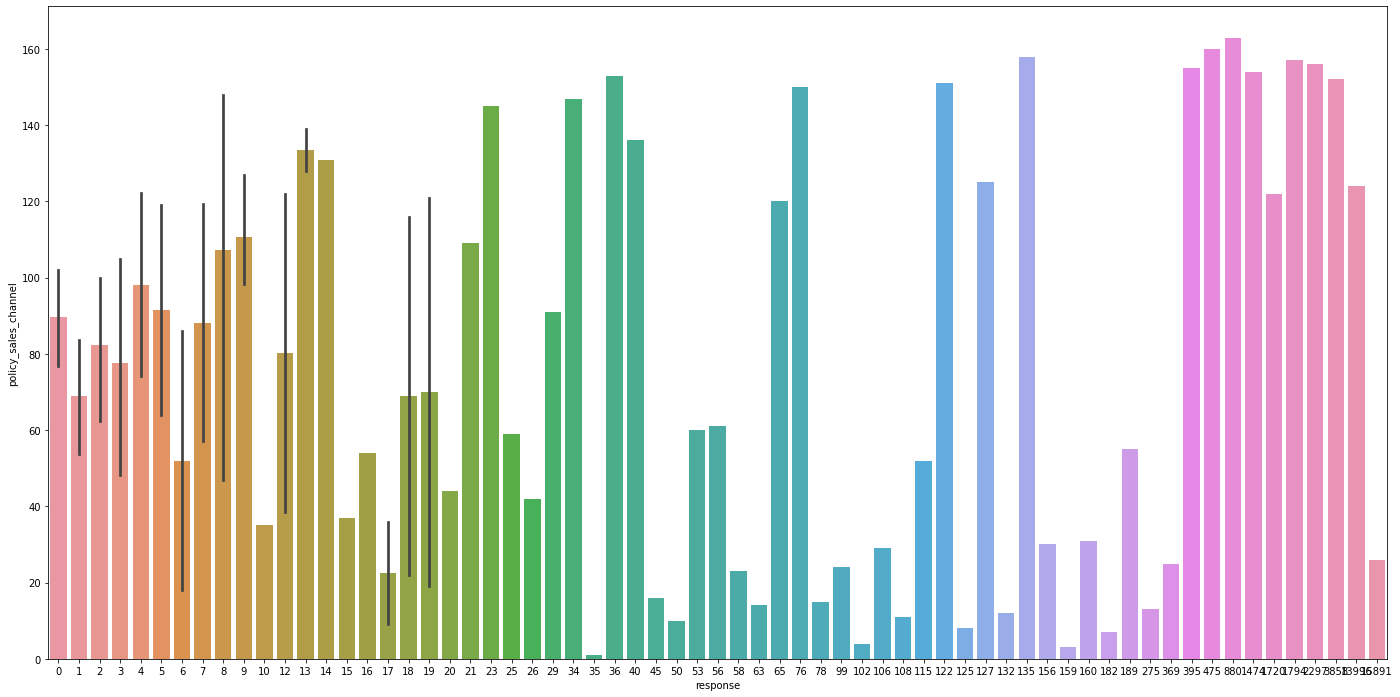

In [71]:
#'policy_sales_channel'
plt.figure( figsize=(24, 12 ))
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux )

<AxesSubplot:xlabel='response', ylabel='vintage'>

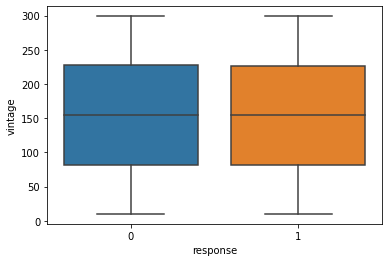

In [72]:
 #'annual_premium'
sns.boxplot( x='response', y='vintage', data=df4 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

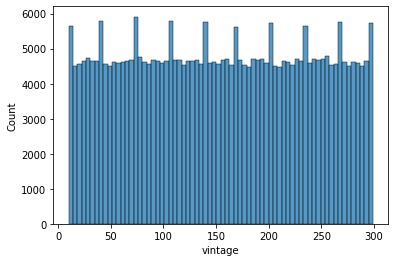

In [73]:
 aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux00 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

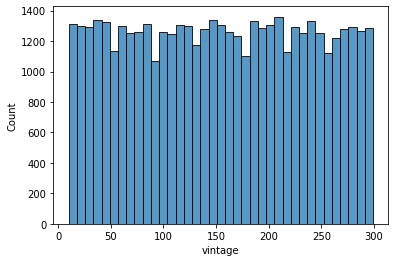

In [74]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 )

# 5.0. Data Preparation

In [135]:
df5 = df4.copy()

In [136]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## Standardization

In [137]:
 ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( 'data/annual_premium_scaler.pkl', 'wb' ) )

## Rescaling

In [138]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( 'data/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( 'data/vintage_scaler.pkl', 'wb' ) )

In [139]:
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## Enconder

In [140]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( 'data/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( 'data/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( 'data/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4. Validation Preparation

In [81]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection

## 6.2. Features Importancia

In [82]:
%%time
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

CPU times: user 2min 34s, sys: 2.84 s, total: 2min 36s
Wall time: 49.4 s


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                    feature  importance
0                   vintage    0.272204
0            annual_premium    0.244497
0                       age    0.164612
0               region_code    0.105398
0            vehicle_damage    0.068430
0      policy_sales_channel    0.061457
0        previously_insured    0.055244
0  vehicle_age_below_1_year    0.014184
0   vehicle_age_between_1_2    0.006259
0                    gender    0.004995
0  vehicle_age_over_2_years    0.002230
0           driving_license    0.000488


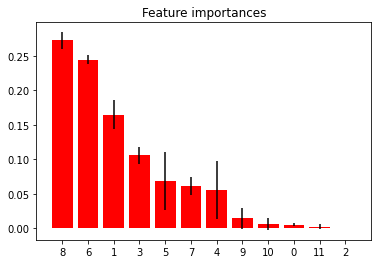

In [83]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning

In [84]:
 cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1. KNN

In [85]:
%%time
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Poder de GENERALIZACAO 
yhat_knn = knn_model.predict_proba( x_val )

CPU times: user 11.5 s, sys: 18.5 ms, total: 11.5 s
Wall time: 11.6 s


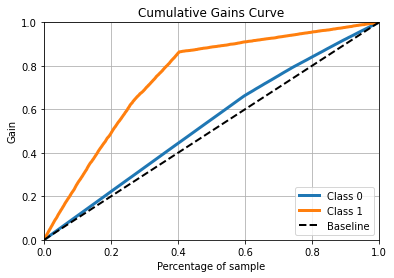

In [86]:
 # Accumulative Gain

skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


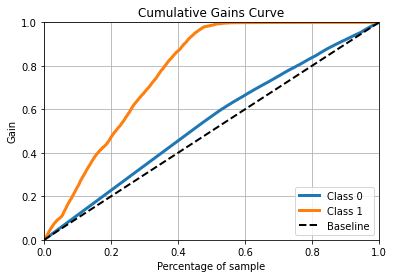

In [87]:
 %time
    # model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

## 7.2. Extra Trees

In [88]:
%%time
# model definition
et = en.ExtraTreesClassifier( n_estimators=500, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train, y_train )

# model predict
yhat_et = et.predict_proba( x_val )

CPU times: user 4min 40s, sys: 6.57 s, total: 4min 46s
Wall time: 1min 35s


In [89]:
# model predict
yhat_et = et.predict_proba( x_val )

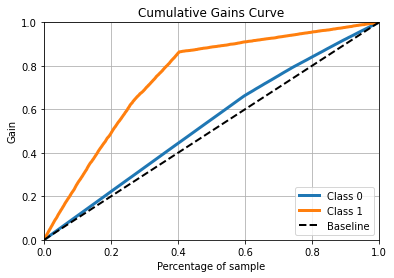

In [90]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

CPU times: user 4.26 s, sys: 2.48 s, total: 6.75 s
Wall time: 2.34 s


<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

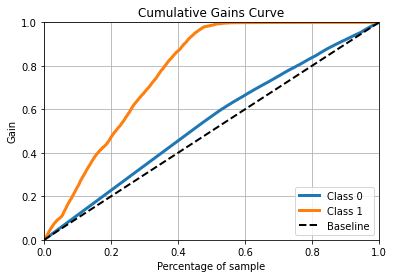

In [91]:
%%time
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

# 8.0. Model Performance

In [92]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [100]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [101]:
# copy dataframe
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df8, k=20 )

# compute recall at k
recall_at_15, data = recall_at_k( df8, k=15 )

TypeError: cannot unpack non-iterable numpy.float64 object

In [102]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score

y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 is in top 2
                    [0.3, 0.4, 0.2],  # 1 is in top 2
                    [0.2, 0.4, 0.3],  # 2 is in top 2
                    [0.7, 0.2, 0.1]]) # 2 isn't in top 2

top_k_accuracy_score(y_true, y_score, k=2)

0.75

In [103]:
y_true = np.array( [1, 0, 1, 1, 0, 1, 0, 0] )
y_score = np.array( [])

## Cummulative Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

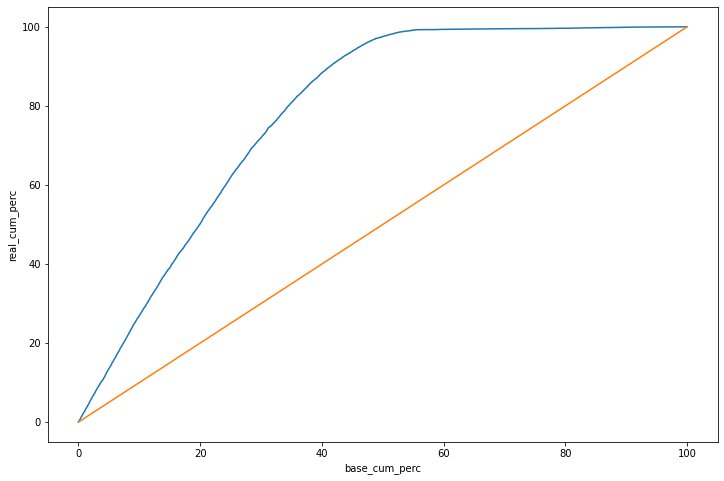

In [120]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

## Lift Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

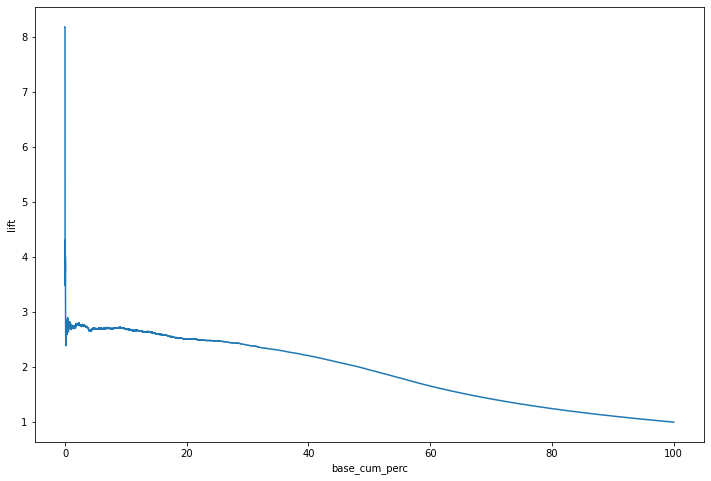

In [105]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

## ROI Curve Manually

In [106]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve


#plt.figure( figsize=(12,8))
#sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [107]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,0.9,144,5184.0,3.6,1.000000,5180.4
8,0.80,0.8,254,8128.0,3.2,0.800000,8124.8
7,0.70,0.7,612,17136.0,2.8,0.622222,17133.2
6,0.60,0.6,1106,26544.0,2.4,0.466667,26541.6
5,0.50,0.5,2012,40240.0,2.0,0.333333,40238.0
4,0.40,0.4,3487,55792.0,1.6,0.222222,55790.4
3,0.30,0.3,5255,63060.0,1.2,0.133333,63058.8
2,0.20,0.2,6955,55640.0,0.8,0.066667,55639.2
1,0.10,0.1,8321,33284.0,0.4,0.022222,33283.6
0,0.01,0.0,48076,0.0,0.0,0.000000,0.0


<AxesSubplot:xlabel='base', ylabel='revenue'>

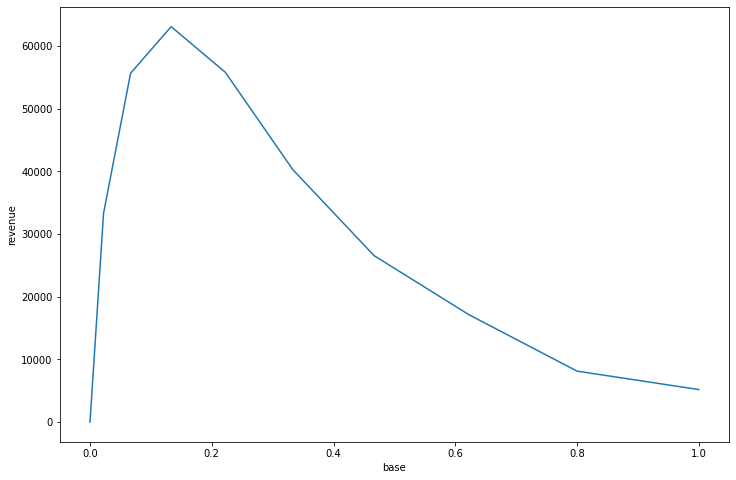

In [108]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )

# 9.0. Deploy to Production

In [112]:
# Save trained model
#pickle.dump( et, open( '/Users/meigarom.lopes/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_health_insurance.pkl', 'wb' ) )
pickle.dump( lr_model, open( 'data/model_linear_regression.pkl', 'wb' ) )

In [114]:
!pwd

/home/wilian/Documentos/Projetos/Data_Science/health_insurance_cross_sell


## 9.1. Health Insurance Class

In [115]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path = '/home/wilian/Documentos/Projetos/Data_Science/health_insurance_cross_sell'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'data/annual_premium_scaler.pkl' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'data/age_scaler.pkl' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'data/vintage_scaler.pkl' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'data/target_encode_gender_scaler.pkl' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'data/target_encode_region_code_scaler.pkl' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'data/fe_policy_sales_channel_scaler.pkl' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
path = '/health_insurance_cross-sell/'
model = pickle.load( open( path + 'data/model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/heathinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

## 9.3. API Tester

In [117]:
import requests

In [118]:
 # loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [119]:
df_test = df_test.sample(10)

In [ ]:
 # convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
data

In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()